In [9]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.ripper import make_ripper_node

In [10]:
dataset_df = pd.read_csv("./data/10_bit_artificial/107.csv")
X_df = dataset_df.drop(columns="class").to_numpy(bool)
y_df = dataset_df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=42, stratify=y_df)

print("Small dataset shapes:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

Small dataset shapes:
X_train: (819, 10), X_test: (205, 10)
y_train: (819,), y_test: (205,)


In [11]:
config = dict(
    layer_node_counts=[8]*3 + [1],
    layer_bit_counts=[4]*4,
    seed=42
)

net = DeepBinaryClassifier(**config, node_factory=make_ripper_node, jobs=8)
%time net.fit(X_train, y_train)
pred_test = net.predict(X_test)
acc_test = accuracy_score(y_test, pred_test)
print(f"Accuracy on test set: {acc_test:.6f}")

CPU times: user 49.1 ms, sys: 119 ms, total: 168 ms
Wall time: 5.18 s
Accuracy on test set: 0.848780


In [12]:
from typing import Dict, Any, List

def describe_architecture_names_full(net) -> Dict[str, Any]:
    if not getattr(net, "layers", None):
        raise RuntimeError("Network not fitted; no layers to describe.")
    if not getattr(net, "node_names", None):
        raise RuntimeError("Missing net.layer_node_names")
    if not getattr(net, "backlinks", None):
        raise RuntimeError("Missing net.backlinks")

    L = len(net.layers)  # number of actual layers (excluding L0)

    # Layers by names (layer 0 are inputs; then layer 1..L are node names)
    layers = [{'layer': l, 'nodes': list(net.node_names[l])} for l in range(L + 1)]

    # Map name -> layer (boundary index)
    name_to_layer: Dict[str, int] = {
        nm: l for l in range(L + 1) for nm in net.node_names[l]
    }

    # Connections: node_name -> parent names (derived from wiring_indices)
    connections: Dict[str, List[str]] = {}
    node_meta: Dict[str, Dict[str, Any]] = {}

    for l in range(1, L + 1):
        prev_names = net.node_names[l - 1]
        curr_names = net.node_names[l]
        idxs_list = net.backlinks[l]  # parents per node (indices into prev_names)

        for j, node in enumerate(net.layers[l - 1]):
            node_name = curr_names[j]
            parent_idxs = list(map(int, idxs_list[j]))
            parent_names = [prev_names[i] for i in parent_idxs]
            connections[node_name] = parent_names

            # Lightweight metadata (robust even if concrete node doesn't expose more)
            meta: Dict[str, Any] = {
                'bits': len(parent_names),
                'parents': parent_names,
            }
            # Optional extras
            if hasattr(node, "get_metadata"):
                try:
                    meta.update(node.get_metadata() or {})
                except Exception:
                    pass
            node_meta[node_name] = meta

    # Collect Used Inputs: all L0 names that appear as parents anywhere
    used_inputs = sorted(
        {nm for parents in connections.values() for nm in parents if nm.startswith("L0N")}
    )

    return {
        'layers': layers,
        'connections': connections,     # node_name -> parent names
        'node_meta': node_meta,
        'name_to_layer': name_to_layer,
        'L': L,
        'used_inputs': used_inputs,
    }


def print_architecture_names_full(desc: Dict[str, Any]) -> None:
    print("Used Inputs:", ", ".join(desc['used_inputs']))
    print("Layers & backlinks:")
    for layer in desc['layers'][1:]:  # skip L0
        l = layer['layer']
        print(f"  L{l}: {len(layer['nodes'])} node(s)")
        for n in layer['nodes']:
            parents = desc['connections'].get(n, [])
            print(f"    {n} - {parents}")


desc = describe_architecture_names_full(net)
print_architecture_names_full(desc)

Used Inputs: L0N0, L0N1, L0N2, L0N3, L0N4, L0N5, L0N6, L0N7, L0N8, L0N9
Layers & backlinks:
  L1: 8 node(s)
    L1N0 - ['L0N1', 'L0N9']
    L1N1 - ['L0N1', 'L0N4', 'L0N5', 'L0N8']
    L1N2 - ['L0N1', 'L0N6', 'L0N7', 'L0N8']
    L1N3 - ['L0N0', 'L0N2', 'L0N3', 'L0N7']
    L1N4 - ['L0N2', 'L0N6', 'L0N7', 'L0N9']
    L1N5 - ['L0N0', 'L0N2', 'L0N8']
    L1N6 - ['L0N1', 'L0N3', 'L0N4', 'L0N5']
    L1N7 - ['L0N1', 'L0N5', 'L0N6', 'L0N9']
  L2: 8 node(s)
    L2N0 - ['L1N0', 'L1N2']
    L2N1 - ['L1N1', 'L1N3', 'L1N5', 'L1N6']
    L2N2 - ['L1N0', 'L1N5']
    L2N3 - ['L1N1', 'L1N2', 'L1N5', 'L1N7']
    L2N4 - ['L1N0']
    L2N5 - ['L1N2', 'L1N3', 'L1N4', 'L1N7']
    L2N6 - ['L1N0', 'L1N1', 'L1N2', 'L1N3']
    L2N7 - ['L1N3', 'L1N5', 'L1N6', 'L1N7']
  L3: 8 node(s)
    L3N0 - ['L2N0', 'L2N2', 'L2N3', 'L2N7']
    L3N1 - ['L2N0', 'L2N2', 'L2N6']
    L3N2 - ['L2N2', 'L2N4', 'L2N6']
    L3N3 - ['L2N2', 'L2N3', 'L2N7']
    L3N4 - ['L2N2', 'L2N4', 'L2N6']
    L3N5 - ['L2N0', 'L2N4', 'L2N5', 'L2N7']
    

In [13]:
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

# --- Global font config: mathtext only (no TeX, no system serif lookup) ---
mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "cm",
    "axes.unicode_minus": False,
    "font.family": "DejaVu Sans",
    "font.weight": "bold"
})

_LN_RE = re.compile(r"^L(\d+)N(\d+)$")

def _contrast_color(face_rgba):
    r, g, b, _ = face_rgba
    L = 0.2126*r + 0.7152*g + 0.0722*b
    return 'black' if L > 0.5 else 'white'

def _label_from_name(nm: str) -> str:
    m = _LN_RE.match(nm)
    if m:
        # Strip layer, keep node index: LxNy -> $N_{y}$
        return rf"$N_{{{int(m.group(2))}}}$"
    return nm  # fallback

def plot_architecture_networkx(
        desc,
        use_used_inputs: bool = True,
        x_gap: float = 3.2,
        y_gap: float = 1.35,
        node_size_pt: float = 34.0,
        edge_width: float = 1.6,
        edge_color: str | None = None,
        figsize=(18, 9),
        aspect: str = 'equal',
):
    layers = desc['layers']
    connections = desc['connections']

    # take nodes layer by layer
    layer_nodes = [list(layer['nodes']) for layer in layers]

    # Optionally filter L0 to only inputs actually referenced by any connection
    if use_used_inputs and layer_nodes and len(layer_nodes[0]) > 0:
        used = set()
        for child, parents in connections.items():
            for p in parents:
                if p.startswith("L0N"):
                    used.add(p)
        if used:
            # keep original order
            layer_nodes[0] = [nm for nm in layer_nodes[0] if nm in used]

    # Labels from node *names* (no continuous enumeration)
    labels = {nm: _label_from_name(nm) for nms in layer_nodes for nm in nms}

    # Layer titles: INPUT / OUTPUT / hidden L_k
    layer_titles = []
    for l in range(len(layer_nodes)):
        if l == 0:
            layer_titles.append(rf"$INPUT$")
        elif l == len(layer_nodes) - 1:
            layer_titles.append(rf"$OUTPUT$")
        else:
            layer_titles.append(rf"$L_{{{l}}}$")

    # Positions (flipped vertically: 0 at top, highest at bottom)
    pos = {}
    for l, nms in enumerate(layer_nodes):
        k = len(nms)
        if k == 0:
            continue
        ys = (np.arange(k)[::-1] - (k - 1) / 2.0) * y_gap  # flipped order
        xs = np.full(k, l * x_gap)
        for i, nm in enumerate(nms):
            pos[nm] = (xs[i], ys[i])

    # Graph
    G = nx.DiGraph()
    G.add_nodes_from(pos)
    for child, parents in connections.items():
        for p in parents:
            if p in pos and child in pos:
                G.add_edge(p, child)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    face = ax.get_facecolor()
    ec = edge_color or _contrast_color(face)

    nx.draw_networkx_edges(G, pos, width=edge_width, edge_color=ec, arrows=False, ax=ax, alpha=0.95)
    nx.draw_networkx_nodes(
        G, pos,
        node_size=node_size_pt**2,
        node_color=[face]*len(G),
        edgecolors=ec,
        linewidths=edge_width,
        ax=ax,
    )
    nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=12,
        font_weight='bold',
        ax=ax,
    )

    # Axes
    ax.set_aspect(aspect, adjustable='box')
    all_y = [y for _, y in pos.values()] or [0]
    pad_y = 0.8
    ax.set_ylim(min(all_y) - pad_y, max(all_y) + pad_y)
    ax.set_xlim(-x_gap * 0.6, x_gap * (len(layer_nodes) - 1) + x_gap * 0.6)
    ax.axis('off')

    # Layer headers
    top_y = max(all_y) + pad_y
    for l, title in enumerate(layer_titles):
        ax.text(l * x_gap, top_y, title, ha='center', va='bottom',
                color=ec, fontweight='bold', fontsize=14)

    plt.show()

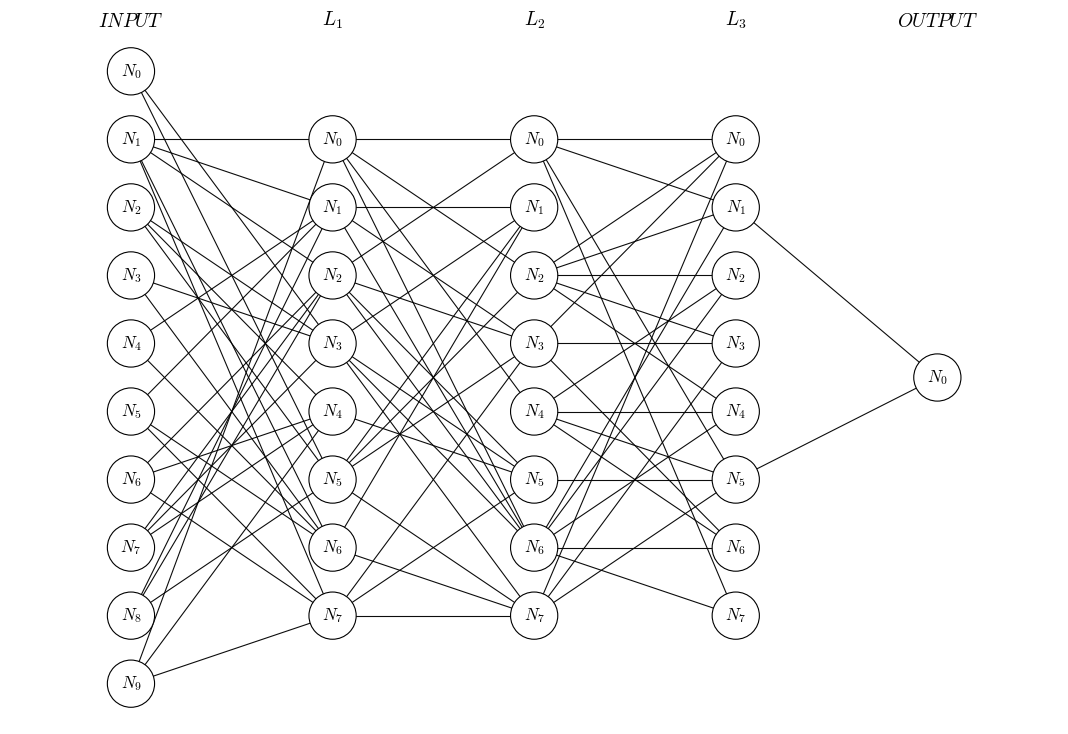

In [14]:
desc = describe_architecture_names_full(net)
plot_architecture_networkx(
    desc,
    x_gap=4,
    figsize=(20, 9),
    edge_width=0.8                  # call it line width maybe
)

In [15]:
def reduce_ripper_net(net) -> "DeepBinaryClassifier":
    for layer in net.layers:
        for node in layer:
            if hasattr(node, "reduce_expression"):
                node.reduce_expression()
    return net



# 1) Reduce all nodes
red_net = reduce_ripper_net(net)
#red_net = net

# 2) Prune unused nodes (keeps all current final outputs; reindexes X_cols)
red_net.prune()

pred_test_after = red_net.predict(X_test)

Accuracy (after pruning): 0.848780 (before: 0.848780)


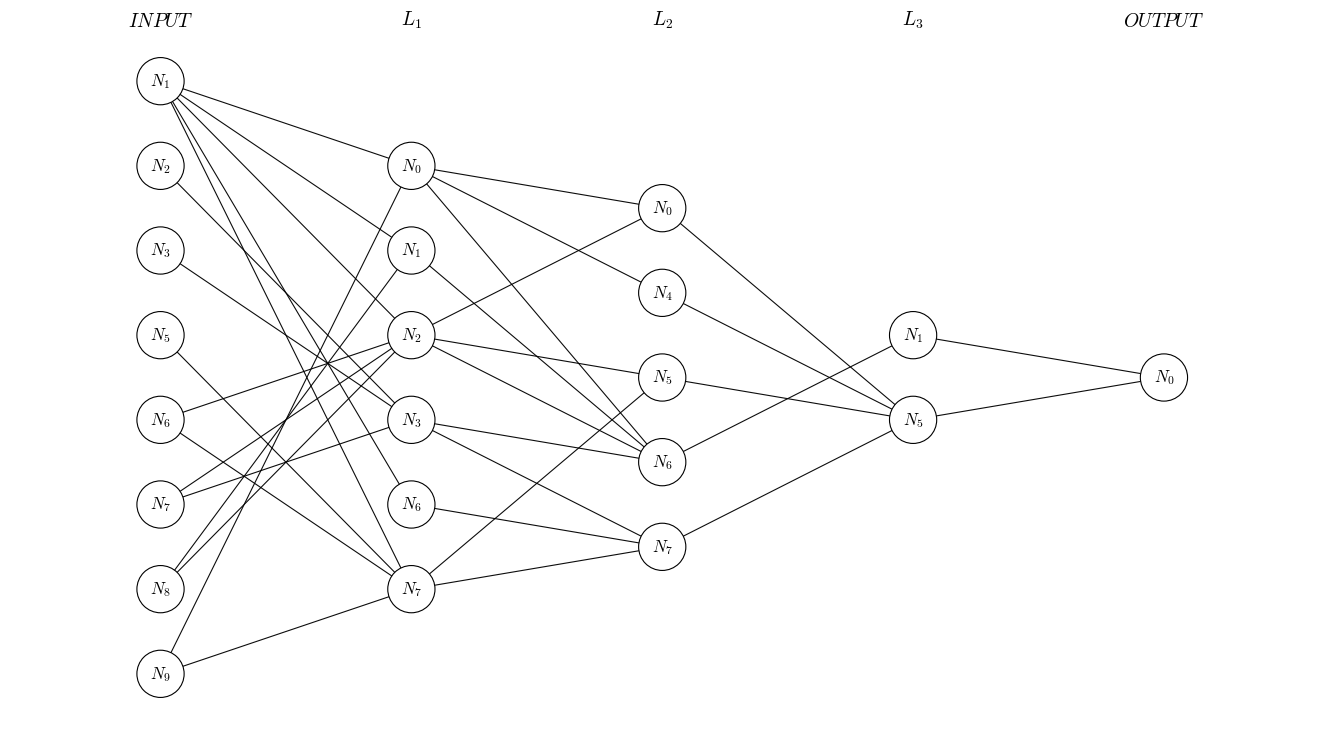

In [16]:

acc_after = accuracy_score(y_test, pred_test_after)
desc_after = describe_architecture_names_full(red_net)
print(f"Accuracy (after pruning): {acc_after:.6f} (before: {acc_test:.6f})")

plot_architecture_networkx(
    describe_architecture_names_full(red_net),
    x_gap=4,
    figsize=(20, 9),
    edge_width=0.8                  # call it line width maybe
)